# The whole lot
Try generating some features for spectra and see if they can be separated with unsupervised learning

In [172]:
import glob
import numpy as np
from scipy.signal import medfilt
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from astropy.table import Table

%matplotlib notebook

In [336]:
file_dir = 'spectra/irs_enhanced/'
files = glob.glob(file_dir+'*tbl')

ok = np.ones(len(files),dtype=bool)
# skip = ('SPITZER_S5_10066432_01_merge.tbl',)
skip = ()
for s in skip:
    num = np.where(file_dir+s == np.array(files))[0].tolist()[0]
    ok[num] = False
    print('skipped {} (#{})'.format(s,num))
    
files = np.array(files)[ok]
print('{} files'.format(len(files)))

16986 files


In [337]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], '{:3.1f}'.format(features[i,0]),
                 color=plt.cm.Set1(features[i,0]),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [360]:
def get_spectrum(file,smooth=False):
    '''Get a spectrum, possibly doing something to it.'''

    t = Table.read(file,format='ascii.ipac')
    if len(np.unique(t['order'])) < 4:
        return None

    return t

    
def get_features(file,plot=False):
    '''Get features for IRS spectra'''

    t = Table.read(file,format='ascii.ipac')
    # 366 is number with four orders present
    if len(t) != 366:
        return None
    
    feat = np.array([])
    
    w = t['wavelength']
    f = t['flux_density']
    e = t['error']
    pos = f > 0
    if np.sum(pos) == 0:
        return None
    logw = np.log10(w[pos])
    logf = np.log10(f[pos])
    
    if plot: plt.loglog(w,f)

    # power-law fit and chi2
    if 1:
        p = np.polyfit(logw,logf,1,w=1/e[pos])
        feat = np.append(feat,p[0])
        chi2 = np.sum( ( (f-10**np.polyval(p,np.log10(w)))/e )**2 ) / len(w)
#         feat = np.append(feat,chi2)
        if plot: plt.plot(w,10**np.polyval(p,np.log10(w)),'--')
    
    # straight line fit and chi2
    if 0:
        p = np.polyfit(w,f,1)
        feat = np.append(feat,p[0])
        chi2 = np.sum( ( (f-np.polyval(p,w))/e )**2 ) / len(w)
        feat = np.append(feat,chi2)
        if plot: plt.plot(w,np.polyval(p,w),':')

    # median filtered spectrum
    if 1:
        filt = medfilt(f,21) / np.median(f)
        neww = 10**np.linspace(np.log10(5.22),np.log10(37.8),20)
        feat = np.append(feat,np.interp(neww,w,filt))
        if plot: plt.plot(neww,np.interp(neww,w,filt))
        
    if plot: plt.show()
    
    return feat

In [383]:
features = []
file_name = []
for file in files[:5000]:
    feat = get_features(file)
    if feat is not None:
        file_name.append(file)
#         if feat[1]>500 or feat[3]>500:
#             continue
        if len(features) == 0:
            features = feat
        else:
            features = np.vstack((features,feat))

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:34: RankWarning: Polyfit may be poorly conditioned


<IPython.core.display.Javascript object>


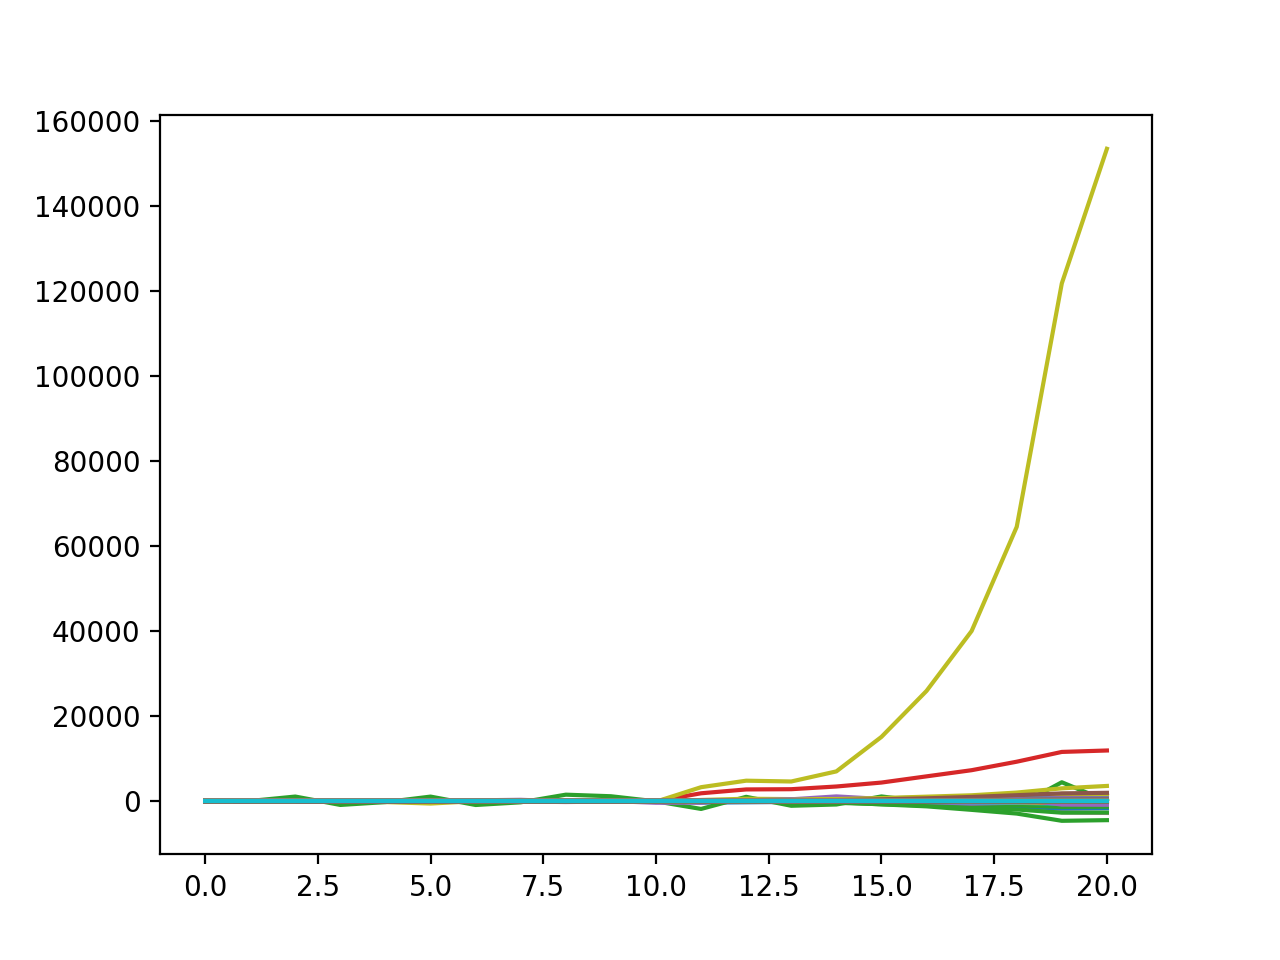

In [384]:
fig,ax = plt.subplots()
for f in features:
    ax.plot(f)

In [389]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from sklearn.decomposition import FastICA, PCA

In [404]:
ica = FastICA(n_components=10)
S_ = ica.fit_transform(features.T)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
S_.shape

(21, 10)

<IPython.core.display.Javascript object>


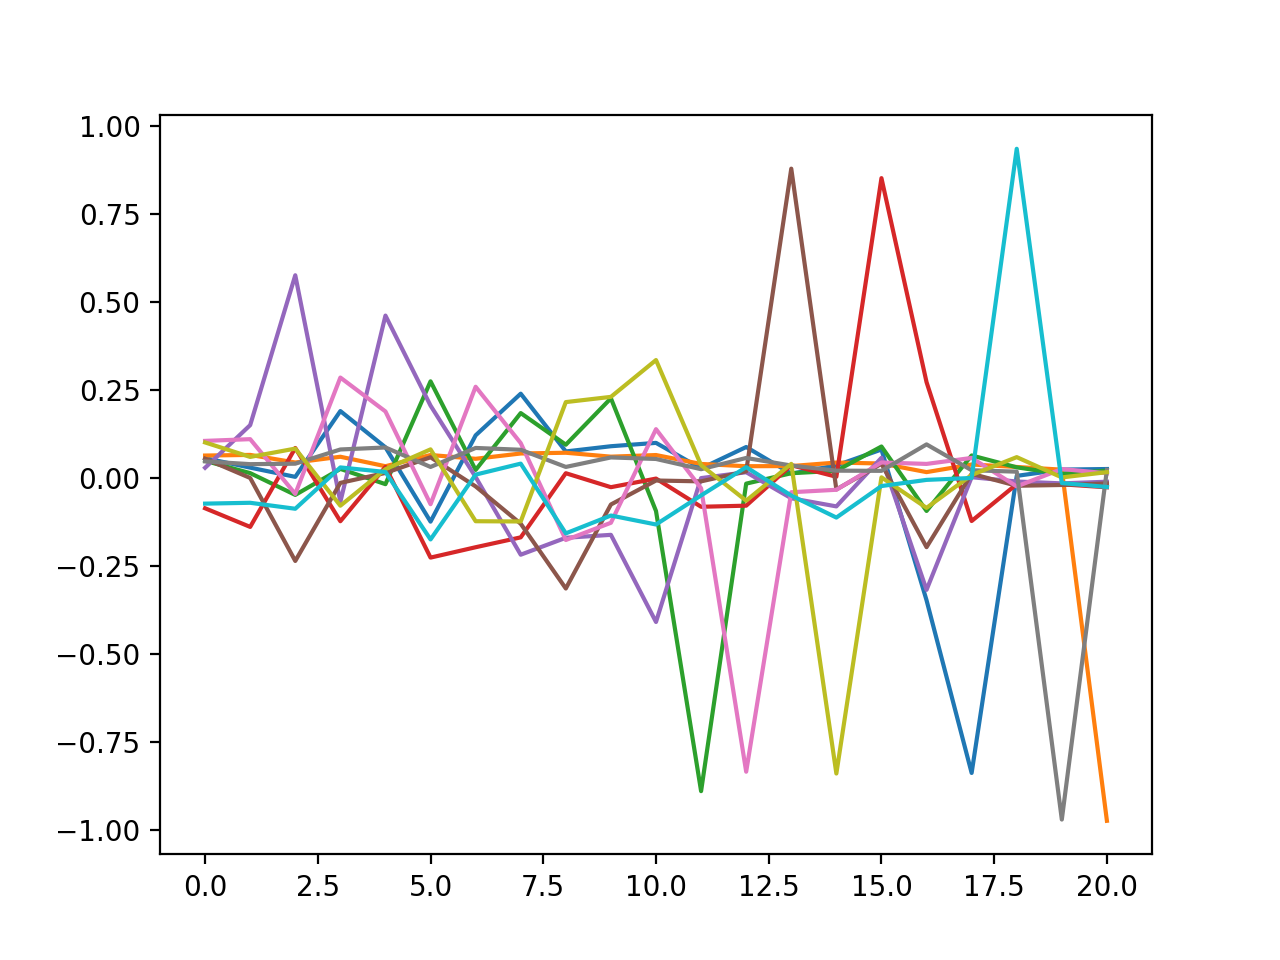

In [405]:
fig,ax = plt.subplots()
for s in S_.T:
    ax.plot(s)

<IPython.core.display.Javascript object>


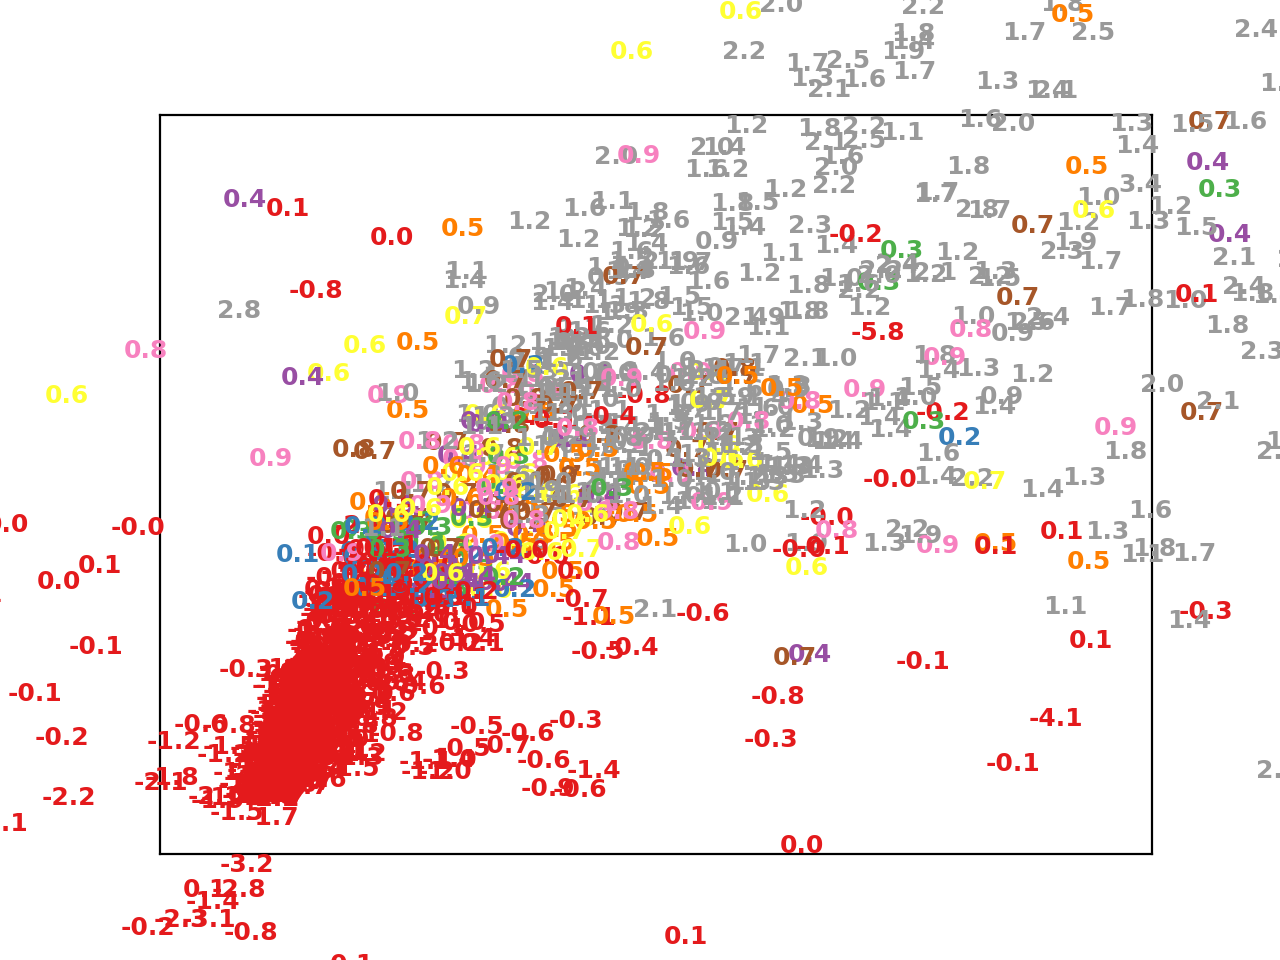

In [388]:
# tsne = TSNE(n_components=2,init='random',learning_rate=300,perplexity=10,n_iter=3000,
#             method='exact',verbose=1)
# x = tsne.fit_transform(features)

plot_embedding(x)

<IPython.core.display.Javascript object>


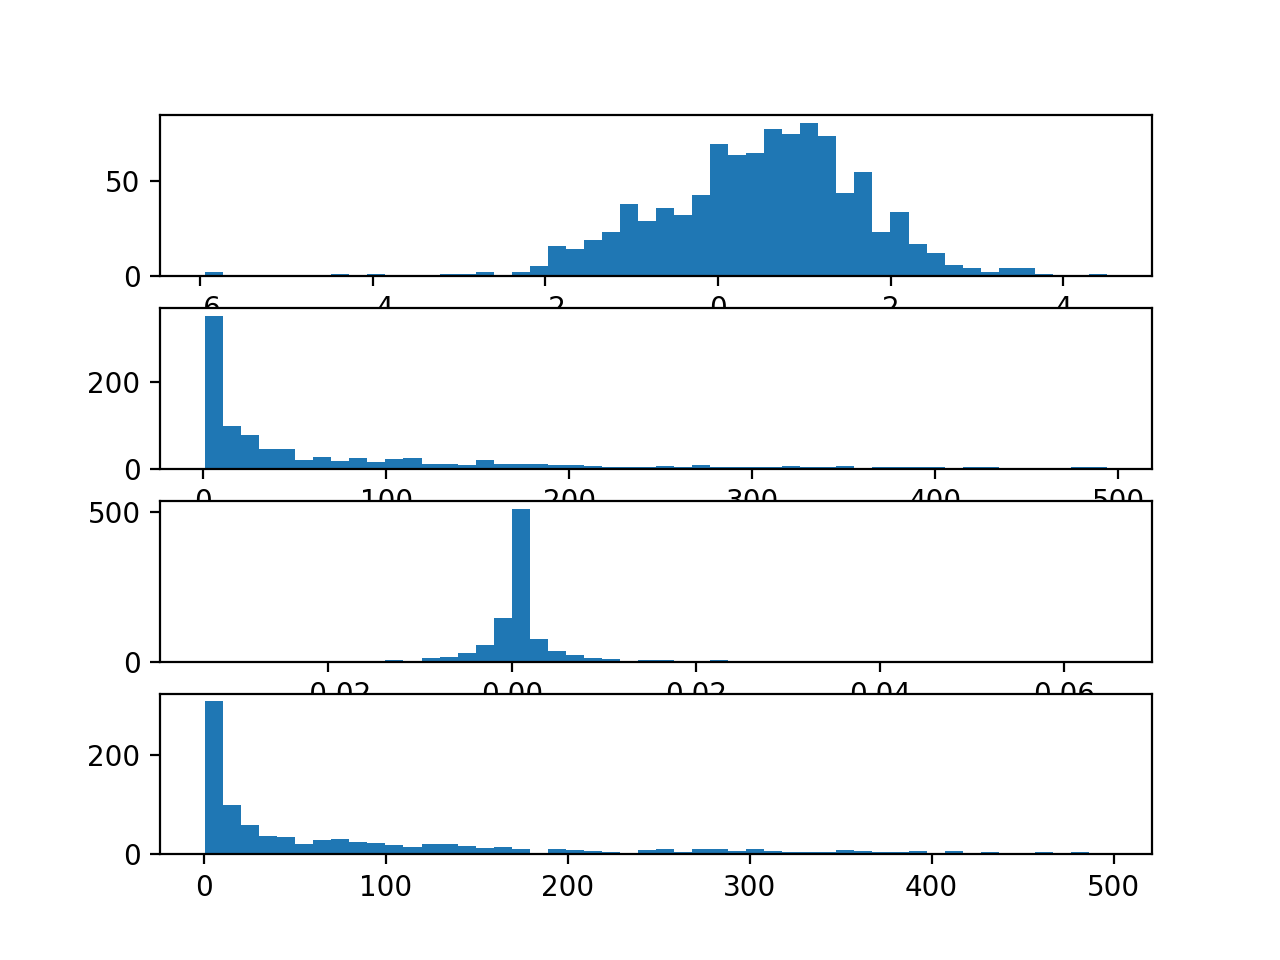

In [164]:
fig,axes = plt.subplots(features.shape[1])
for i,ax in enumerate(axes):
    ax.hist(features[:,i],bins=50)

In [283]:
n = np.argmax(features[:,-1])
print(features[n])
file_name[n]

[ -9.92146164e-05  -2.45667625e-03  -4.88700000e-03  -3.05644307e-03
  -8.25200000e-03  -5.25096500e-03   2.71700000e-03   1.90523005e-04
   1.06550000e-02   2.47779440e-02   8.16357439e-01   3.23312100e+00
   6.08820980e+00   9.05868618e+00   1.46786428e+01   1.90714257e+01
   2.58328989e+01   2.97268487e+01   3.74015449e+01   3.54830917e+01]


'spectra/irs_enhanced/SPITZER_S5_10065664_01_merge.tbl'

<IPython.core.display.Javascript object>


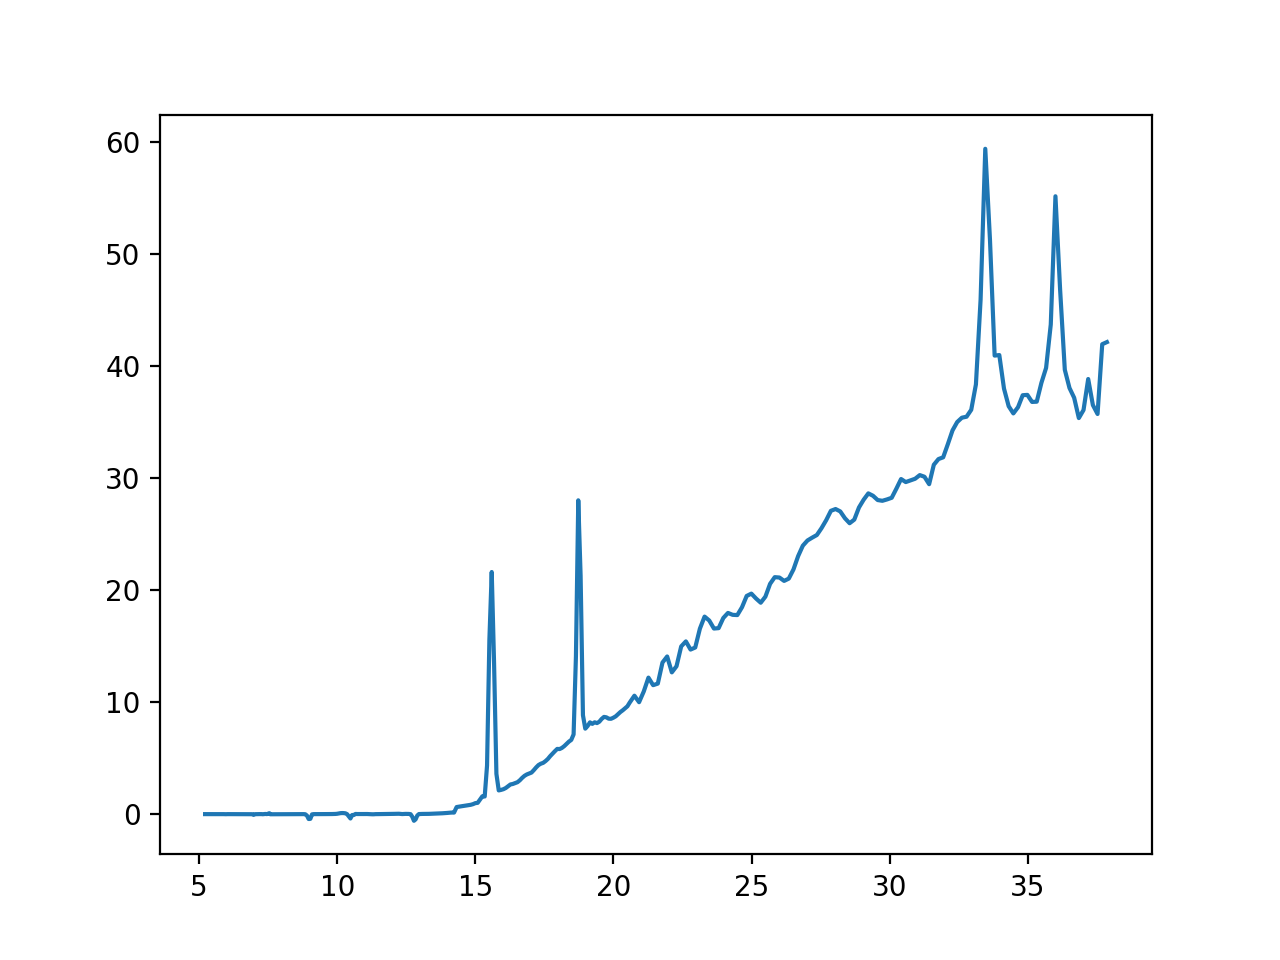

In [284]:
t = Table.read('spectra/irs_enhanced/SPITZER_S5_10065664_01_merge.tbl',format='ascii.ipac')
fig,ax = plt.subplots()
ax.plot(t['wavelength'],t['flux_density'])

In [288]:
t.meta

OrderedDict([('comments', []),
             ('keywords',
              OrderedDict([('AORKEY',
                            {'value': '10065664          / Observation request ID'}),
                           ('TGT_NUM',
                            {'value': '01                / Nth target observed in this AOR'}),
                           ('OBJECT',
                            {'value': "'NGC6543-edge'    / Object name specified by observer"}),
                           ('AORLABEL',
                            {'value': 'calwav_010-NGC6543-0123-S'}),
                           ('PROTITLE',
                            {'value': 'SIRTF IRS Calibration Program'}),
                           ('EXPTYPE', {'value': 'wav'}),
                           ('OBJTYPE', {'value': 'TargetFixedSingle'}),
                           ('DATE_OBS',
                            {'value': "'2004-07-14 18:06:25.802' / start of first observation (UTCS)"}),
                           ('SCLK_OBS',
             